<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: to turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (Vit) architecture/paper with PyTorch: https://arvix.org/abs/2010.11929

See ground trugh notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup

Let's import code we've previously written + required libraries.

In [1]:
# Get the going modular scripts
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py .  # get the helper_functions.py script
!rm -rf pytorch-deep-learning

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 56.87 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
!pip install -q torchinfo

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [86]:
import matplotlib.pyplot as plt
import random
import requests
import torch
import torchvision

from going_modular.going_modular import data_setup, engine, utils
from helper_functions import download_data, set_seeds, plot_loss_curves, pred_and_plot_image
from pathlib import Path
from torch import nn
from torchinfo import summary
from torchvision import transforms

In [5]:
# Setup device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data
The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem. To do that, we need some data. Namely, the pizza, steak and sushi image we've been using so far.

In [6]:
# Download pizza, steak, sushi images from Github
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
    )

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [8]:
# Create image size
IMG_SIZE = 224  # comes from Table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE), antialias=None),
    transforms.ToTensor(),
    ])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [9]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for
# our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
    )

In [10]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3. Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize*!

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

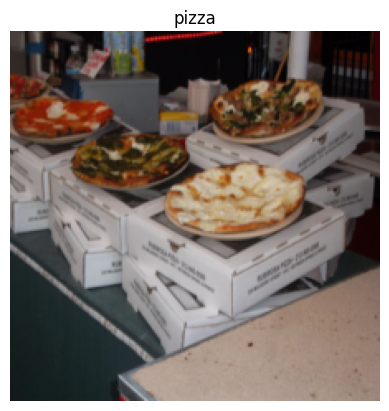

In [12]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating. So in order to make it more understandablewe can break it down into smaller pieces.

* **Inputs** - What goes into the models? (in our case, image tensors)
* **Outputs** - What come out of the mode/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1. ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: differente hyperparameters for the architecture/training.
* Text

#### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transform paper"/>

* Embedding = learnable representation (start with random number and improve over time)

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

##### Section 3.1

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a $1 \mathrm{D}$ sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, img_patch_1, img_patch_2, ..., img_patch_N]
    + [class_token_pos, img_patch_1_pos, img_patch_2, pos, ..., img_patch_N_pos]
```

---



**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_inptut

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

---



**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP classification head = one hidden layer at training time
* MLP classification head = single linear layer at fine-tuning time

In pseudo code:
```python
 # Equation 4
 y = Linear_layer(LN_layer(x_output_MLP_block))
```

---


### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of the transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neuros in the MLP
* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layer = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1. Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a $1 \mathrm{D}$ sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: ${H}\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N}\times\left(P^{2}\cdot{C}\right)$
* ${H}$ = heith
* ${W}$ = width
* ${C}$ = color channels
* ${P}$ = patch size
* ${N}$ = number of patches = ${H}{W}/{P}^{2}$
* ${D}$ = constant latent vector size = embedding dimension (see Table 1)

In [13]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [14]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_paches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_paches, embedding_dimension)


### 4.2. Turning a single into patches

Let's *visualize, visualize, visualize!*

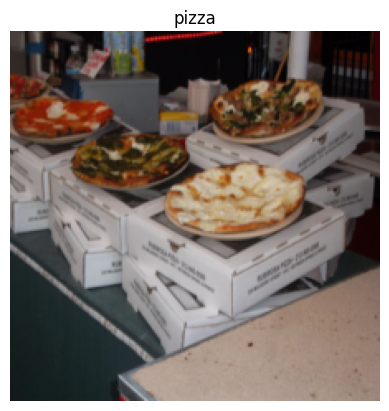

In [15]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
image.shape

torch.Size([3, 224, 224])

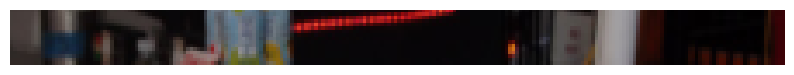

In [17]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # convert image to color channels last (H, W ,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(10, 10))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


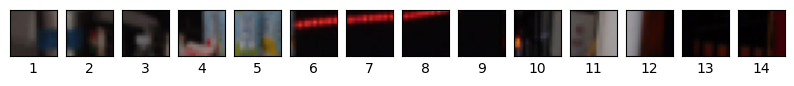

In [18]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = int(img_size / patch_size)
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}")
print(f"Patch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=num_patches,  # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(10, 10)
    )

# Iterate through number of patches in the top row.
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)  # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


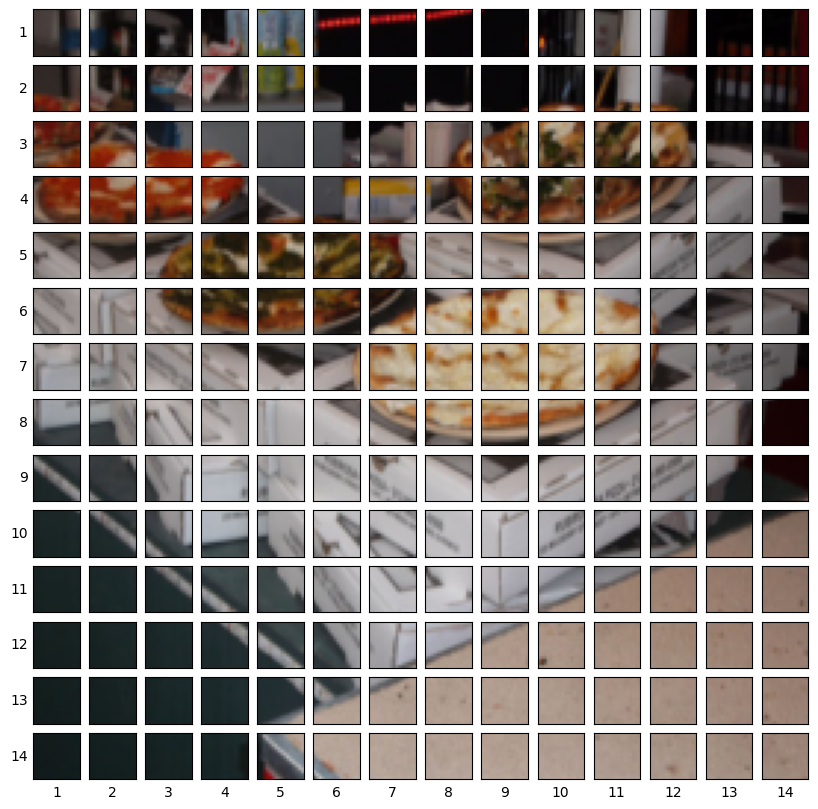

In [19]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = int(img_size / patch_size)
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}")
print(f"Number of patches per column: {num_patches}")
print(f"Total patches: {num_patches * num_patches}")
print(f"Patch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=num_patches,
    ncols=num_patches,
    sharex=True,
    sharey=True,
    figsize=(10, 10),
    )

# Loop through height and width of image
for i, h in enumerate(range(0, img_size, patch_size)):  # iterate through height
    for j, w in enumerate(range(0, img_size, patch_size)):  # iterage through width
        axs[i][j].imshow(image_permuted[h:h+patch_size, w:w+patch_size, :]);
        axs[i][j].set_ylabel(
            i+1,
            rotation="horizontal",
            horizontalalignment="right",
            verticalalignment="center"
            )
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()

plt.show()

### 4.3. Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.

In [20]:
# Create conv2d layer to turn image in to patches of learnable feat maps (embeddings)

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,  # for color images
    out_channels=768,  # D size from Table 1 for ViT-Base
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
    )

In [21]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension -> (batch_size, color_channels, height, width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14])  # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional features maps from indexes: [252, 608, 555, 342, 230]


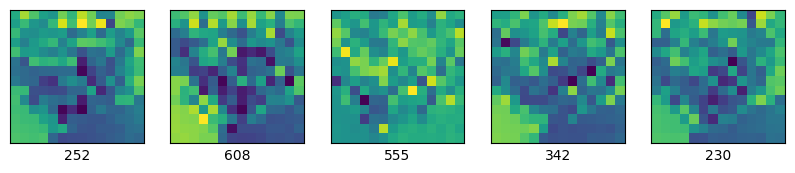

In [22]:
# Plot random convolutional feature maps (embeddings)
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional features maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(10, 10),
    )

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[i].set_xlabel(idx)

### 4.4. Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional features maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [23]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [24]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

In [25]:
# Put everything together
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


In [26]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


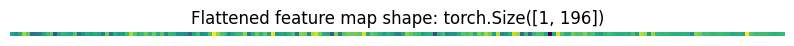

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(10, 10))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5. Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:

1. Create a class clalled `PatchEmbedding` that inherits from `nn.MModule`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` that defineees the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output of the patch embedding

In [28]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(
            self,
            in_channels: int=3,
            patch_size: int=16,
            embedding_dim: int=768,  # from Table 1 for ViT-Base
            ) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        # 3. Create a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
            )

        # 4. Create a layer to flatten feature map output of Conv2d
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3,
            )

    # 5. Define a foward method to define the forward computation steps
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Create assertion to check that inp;ut are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0,  f"Imput image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make the returned sequence embedding dimension are in the right order (batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0, 2, 1)

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768,
    )

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### 4.6. Creating the class token embedding

Want to: prepend a learnable a class token to the start of the patch embedding.

In [30]:
patch_embedded_image

tensor([[[-0.2327,  0.0735, -0.0555,  ...,  0.0715, -0.1206,  0.1599],
         [-0.0113,  0.0188, -0.0691,  ...,  0.1575, -0.1476, -0.1041],
         [-0.1727, -0.0427,  0.0167,  ...,  0.1617, -0.0462,  0.0265],
         ...,
         [-0.6590,  0.1393, -0.1790,  ...,  0.4335, -0.2685,  0.2433],
         [-0.5791,  0.1268, -0.1697,  ...,  0.4190, -0.2735,  0.2409],
         [-0.5822,  0.1241, -0.1630,  ...,  0.4233, -0.2739,  0.2052]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Get tjhe batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# Create class token embedding as a learnable parameber that shares the same
# as the embedding dimension (D)
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True,
    )

class_token.shape

torch.Size([1, 1, 768])

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat(
    tensors=(class_token, patch_embedded_image),
    dim=1,
    )

print(f"\nSequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dimension)")
patch_embedded_image_with_class_embedding


Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dimension)


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2327,  0.0735, -0.0555,  ...,  0.0715, -0.1206,  0.1599],
         [-0.0113,  0.0188, -0.0691,  ...,  0.1575, -0.1476, -0.1041],
         ...,
         [-0.6590,  0.1393, -0.1790,  ...,  0.4335, -0.2685,  0.2433],
         [-0.5791,  0.1268, -0.1697,  ...,  0.4190, -0.2735,  0.2409],
         [-0.5822,  0.1241, -0.1630,  ...,  0.4233, -0.2739,  0.2052]]],
       grad_fn=<CatBackward0>)

### 4.7. Creating the position embedding

Want to: create a series of 1D learnable position embeddings and add them to the sequence of patch embeddings

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2327,  0.0735, -0.0555,  ...,  0.0715, -0.1206,  0.1599],
          [-0.0113,  0.0188, -0.0691,  ...,  0.1575, -0.1476, -0.1041],
          ...,
          [-0.6590,  0.1393, -0.1790,  ...,  0.4335, -0.2685,  0.2433],
          [-0.5791,  0.1268, -0.1697,  ...,  0.4190, -0.2735,  0.2409],
          [-0.5822,  0.1241, -0.1630,  ...,  0.4233, -0.2739,  0.2052]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(
    torch.ones(batch_size, number_of_patches+1, embedding_dimension),
    requires_grad=True,
    )

position_embedding.shape

torch.Size([1, 197, 768])

In [36]:
# Add the positino embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
patch_and_position_embedding

Patch and position embedding shape: torch.Size([1, 197, 768])


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7673, 1.0735, 0.9445,  ..., 1.0715, 0.8794, 1.1599],
         [0.9887, 1.0188, 0.9309,  ..., 1.1575, 0.8524, 0.8959],
         ...,
         [0.3410, 1.1393, 0.8210,  ..., 1.4335, 0.7315, 1.2433],
         [0.4209, 1.1268, 0.8303,  ..., 1.4190, 0.7265, 1.2409],
         [0.4178, 1.1241, 0.8370,  ..., 1.4233, 0.7261, 1.2052]]],
       grad_fn=<AddBackward0>)

### 4.8. Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's see it all in one cell.

In [37]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768,
    )

# 5. Pass image through
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True,
    )
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(batch_size, number_of_patches+1, embedding_dimension),
    requires_grad=True,
    )
print(f"Position embedding shape: {position_embedding.shape}")

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Position and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Position and position embedding shape: torch.Size([1, 197, 768])


In [38]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7673, 1.0735, 0.9445,  ..., 1.0715, 0.8794, 1.1599],
         [0.9887, 1.0188, 0.9309,  ..., 1.1575, 0.8524, 0.8959],
         ...,
         [0.3410, 1.1393, 0.8210,  ..., 1.4335, 0.7315, 1.2433],
         [0.4209, 1.1268, 0.8303,  ..., 1.4190, 0.7265, 1.2409],
         [0.4178, 1.1241, 0.8370,  ..., 1.4233, 0.7261, 1.2052]]],
       grad_fn=<AddBackward0>)

## 5. Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?

    * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.

    * We want our neural network (ViT) to learn this relationship/representation.

* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

    * Normalization = make everything have the same mean and same standard deviation.
    * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimensions.
    * When we normalize along the embedding dimension, it's like making all the of the stairs of the staircase the same same.





In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-heas self-attention block ('MSA block' for short)
    """
    def __init__ (
            self,
            embedding_dim: int=768,  # Hidden size D (embedding dimension) from Table 1 for ViT-Base
            num_heads: int=12,  # Heads from Table 1 for ViT-Base
            attn_dropout: float=0.0,
            ) -> None:
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,  # is the batch first? (batch, seq, feature) -> (batch, num_of_patches, embedding_dimension)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False,
            )

        return attn_output

In [40]:
# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0,
    )

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_embedded_image_with_class_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
    * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
    * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, the're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
    * MLP number of hidden units = MLP Size in Table 1
    * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU

* **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positionals after adding positional- to patch embeddings.
    * Value for Dropout available in Table 3


In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [41]:
class MLPBlock(nn.Module):
    def __init__(
            self,
            embedding_dim: int=768,
            mlp_size: int=3072,
            dropout: float=0.1
            ) -> None:
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size,
                ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim,
                ),
            nn.Dropout(p=dropout),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(self.layer_norm(x))

In [42]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(
    embedding_dim=768,
    mlp_size=3072,
    dropout=0.1,
    )

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from goint too small)

In pseudo code:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

## 7.1. Create a custom Transformer Encoder block

In [43]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
            self,
            embedding_dim: int=768,  # Hidden size D from table 1, 768 for ViT-Base
            num_heads: int=12,  # from table 1
            mlp_size: int=3072,  # from table 1
            mlp_dropout: float=0.1,  # from table 3
            attn_dropout: float=0.0
            ) -> None:
        super().__init__()

        # Create MSA block (equation 3)
        self.msa_block = MultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout,
            )

        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x  # residual/skip connection for equation 2
        x = self.mlp_block(x) + x  # residual/skip connection for equation 3
        return x

In [44]:
# Create an instance of TransformeEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),  # (batch_size, numer_of_patches, embedding_dimension)
    col_names=["input_size", "num_params"],
    col_width=20,
    row_settings=["var_names"],
    )

Layer (type (var_name))                            Input Shape          Param #
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        --
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        --
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        1,536
│    └─MultiheadAttention (multihead_attn)         --                   2,362,368
├─MLPBlock (mlp_block)                             [1, 197, 768]        --
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        1,536
│    └─Sequential (mlp)                            [1, 197, 768]        --
│    │    └─Linear (0)                             [1, 197, 768]        2,362,368
│    │    └─GELU (1)                               [1, 197, 3072]       --
│    │    └─Dropout (2)                            [1, 197, 3072]       --
│    │    └─Linear (3)                             [1, 197, 3072]       2,360,064
│    │    └─Dropout (4)                            [1, 197, 768]    

## 7.2. Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand. But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [45]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,  # embedding size from table 1
    nhead=12,  # heads from table 1
    dim_feedforward=3072,  # MLP size from tabel 1
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True,
    )

In [46]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# Get a summary using torchinfo.summary
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),  # (batch_size, numer_of_patches, embedding_dimension)
    )

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 197, 768]             7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it with a single PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behind de scenes, we can tweak them if necessary.

What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benefit of speed ups (performance boots)

## 8. Putting it all together to create ViT

In [48]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(
            self,
            img_size: int=224,  # Table 3 from the ViT paper
            in_channels: int=3,
            patch_size: int=16,
            num_transformer_layers=12,  # Table 1 for "Layers" for ViT
            embedding_dim: int=768,  # Hidden size D from Table 1 for ViT-Base
            mlp_size: int=3072,  # Table 1
            num_heads: int=12,  # Table 1
            attn_dropout: float=0.0,
            mlp_dropout: float=0.1,
            embedding_dropout: float=0.1,  # Dropout for patch and position embeddings
            num_classes: int=1000,  # Number of classes in our classification problem
            ) -> None:

        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by" \
            f"patch_size, image: {img_size}, patch_size: {patch_size}"

        # Calculate the number of patches
        self.num_patches = int((img_size * img_size) / patch_size**2)

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True,
            )

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches+1, embedding_dim),
            requires_grad=True,
            )

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim,
            )

        # Create the Transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout,
            ) for _ in range(num_transformer_layers)])

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(
                in_features=embedding_dim,
                out_features=num_classes,
                )
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimension

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)  # (batch_size, number_of_patchees, embedding_dim)

        # Add position embedding to class token and patch embedding (equation 1)
        x = self.position_embedding + x

        # Apply dropout to patch embedding
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x

In [49]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT
vit = ViT(num_classes=3)

# Pass the random image tensor to our ViT instance
vit.eval()
with torch.inference_mode():
    y_pred_logit = vit(random_image_tensor)

y_pred_logit

tensor([[0.1175, 0.8695, 1.1825]])

### 8.1. Getting a visual summary of our ViT model

In [50]:
# Get a summary using torchinfo.summary
summary(
    model=vit,
    input_size=(1, 3, 224, 224),  # (batch_size, numer_of_patches, embedding_dimension)
    )

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 3]                    152,064
├─PatchEmbedding: 1-1                              [1, 196, 768]             --
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                                [1, 768, 196]             --
├─Dropout: 1-2                                     [1, 197, 768]             --
├─Sequential: 1-3                                  [1, 197, 768]             --
│    └─TransformerEncoderBlock: 2-3                [1, 197, 768]             --
│    │    └─MultiHeadSelfAttentionBlock: 3-1       [1, 197, 768]             2,363,904
│    │    └─MLPBlock: 3-2                          [1, 197, 768]             4,723,968
│    └─TransformerEncoderBlock: 2-4                [1, 197, 768]             --
│    │    └─MultiHeadSelfAttentionBlock: 3-3       [1, 197, 768]             2,363,904
│   

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

### 9.1. Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9 and $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

### 9.2. Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it'a a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

### 9.3. Training our ViT Model

In [51]:
set_seeds()

# Creating the optimizer
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=0.1,
    )

# Creating the loss function
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


### 9.4. What our training setup is missing

How is our training setup different to the ViT paper? We've replicated model architecture correctly. But what was differente between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main thinkgs our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base learning rate
* Learning reate decay - as your model get close to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

Search "pytorch [technique name]"

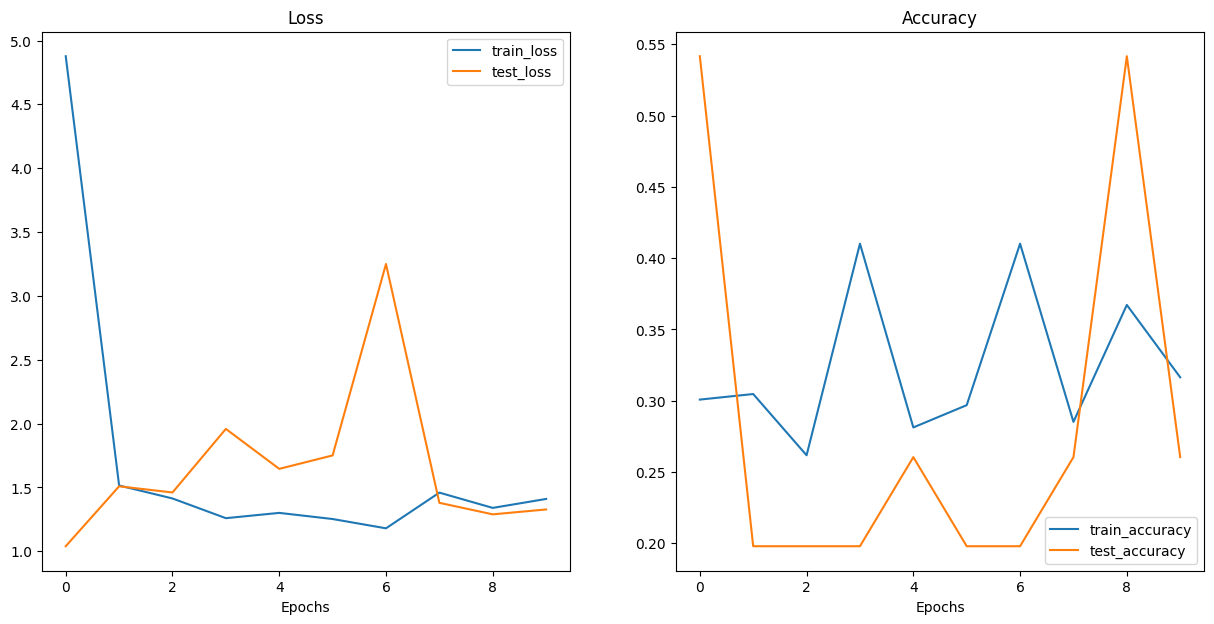

In [52]:
### 9.5. Plotting loss curves for our model
plot_loss_curves(results)

## 10. Using a pretrained ViT from  `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning, git it a got, it often achieves great results with little data.



### 10.1 Why use a pretained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [54]:
# Cost of a TPUv2 for 30 days
cost = 30 * 24 * 8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost:.2f} USD")

Cost of renting a TPUv3 for 30 straight days: $5760.00 USD


In [57]:
# The following requires torchvision v1.12+ and torchvision 0.13+
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


### 10.2. Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [70]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(
    weights=pretrained_vit_weights
    ).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(
    in_features=embedding_dimension,
    out_features=len(class_names),
    ).to(device)

In [71]:
# Get a summary using torchinfo.summary
summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),  # (batch_size, numer_of_patches, embedding_dimension)
    col_names=["output_size", "trainable"],
    row_settings=["var_names"]
    )

Layer (type (var_name))                                      Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [1, 3]                    Partial
├─Conv2d (conv_proj)                                         [1, 768, 14, 14]          False
├─Encoder (encoder)                                          [1, 197, 768]             False
│    └─Dropout (dropout)                                     [1, 197, 768]             --
│    └─Sequential (layers)                                   [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_3)                   [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_4)                   [1, 19

### 10.3. Preparing data for the pretrained ViT Model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [73]:
# Get automatic transforms from pretraind VvT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [74]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=BATCH_SIZE
    )

### 10.4. Train feature extractor ViT model

In [75]:
set_seeds()

# Creating the optimizer
optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=0.1,
    )

# Creating the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
vit_pretrained_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7662 | train_acc: 0.7188 | test_loss: 0.5440 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3442 | train_acc: 0.9453 | test_loss: 0.3269 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2081 | train_acc: 0.9531 | test_loss: 0.2718 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1576 | train_acc: 0.9609 | test_loss: 0.2438 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1268 | train_acc: 0.9727 | test_loss: 0.2297 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1258 | train_acc: 0.9766 | test_loss: 0.2152 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0981 | train_acc: 0.9766 | test_loss: 0.2396 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0854 | train_acc: 0.9844 | test_loss: 0.2311 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1166 | train_acc: 0.9883 | test_loss: 0.2084 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0741 | train_acc: 0.9922 | test_loss: 0.1813 | test_acc: 0.9176


### 10.5. Plot the loss curves of our pretrained ViT feature extractor model

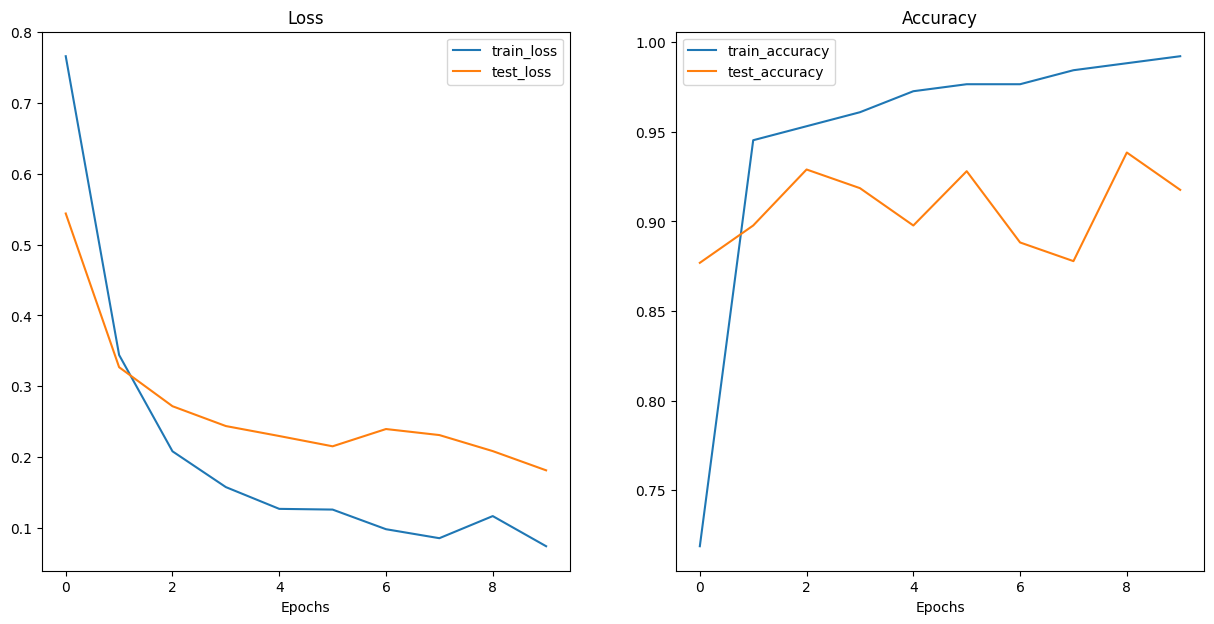

In [78]:
plot_loss_curves(vit_pretrained_results)

### 10.6. Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to computer restrictions.

In [81]:
utils.save_model(
    model=pretrained_vit,
    target_dir="models",
    model_name="08_pretrained_vit_feature_exctractor_pizza_state_sushi.pth",
    )

[INFO] Saving model to: models/08_pretrained_vit_feature_exctractor_pizza_state_sushi.pth


In [84]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_exctractor_pizza_state_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far or our FoodVisioni Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a larget file/might not make predictions as fast as a smaller model).

## 11. Predicting a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


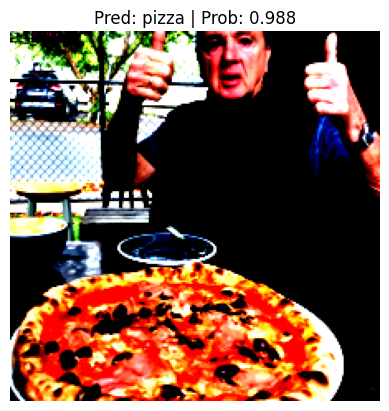

In [88]:
# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(
    model=pretrained_vit,
    image_path=custom_image_path,
    class_names=class_names,
    transform=vit_transforms,
    device=device
    )